<a href="https://colab.research.google.com/github/Yugsolanki/bone-fracture-detection-using-x-rays/blob/main/Bone_Fracture_Detection_using_X_Rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d vuppalaadithyasairam/bone-fracture-detection-using-xrays

In [ ]:
!unzip /content/bone-fracture-detection-using-xrays.zip

In [42]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GaussianNoise
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
# Define constants and directories
train_path = '/content/archive (6)/train'
test_path = '/content/archive (6)/val'

# Helper Funtions

In [25]:
# Function to plot sample images
def plot_sample_images(data_path, num_samples=5):
    plt.figure(figsize=(15, 5*len(os.listdir(data_path))))
    for i, class_name in enumerate(os.listdir(data_path)):
        class_path = os.path.join(data_path, class_name)
        images = random.sample(os.listdir(class_path), num_samples)
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(224, 224))
            plt.subplot(len(os.listdir(data_path)), num_samples, i*num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}\n{img_name}", fontsize=50/num_samples)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

In [26]:
# Function to plot pixel distribution
def plot_pixel_distribution(generator, title):
    # Get a batch of images
    batch_images, _ = next(generator)
    # Flatten the pixel values
    pixels = batch_images.flatten()

    # Plot pixel distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(pixels, bins=50, kde=True, color='blue')
    plt.title(f"Pixel Intensity Distribution: {title}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

In [27]:
# Function to visualize augmentation
def visualize_augmentation(generator):
    # Get a batch of original images
    original_images, _ = next(generator)

    # Apply augmentations
    augmented_images = next(generator)[0]

    plt.figure(figsize=(10, 5))
    for i in range(4):
        plt.subplot(2, 4, i + 1)
        plt.imshow(original_images[i].astype('uint8'))
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, 4, i + 5)
        plt.imshow(augmented_images[i].astype('uint8'))
        plt.title("Augmented")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [71]:
# Function to plot graph of metric and optional validation metric
def plot_metrics1(title, metric, val_metric=None):
    # Create the figure
    plt.figure(figsize=(10, 6))

    # Plot the training metric
    plt.plot(history.history[metric], label=f'Training {title}')
    plt.axhline(y=history.history[metric][-1], color='red', linestyle='--', label=f'Final Training {title}')

    # Add annotations for training metric milestones
    plt.annotate('Initial: {:.2e}'.format(history.history[metric][0]), xy=(0, history.history[metric][0]),
                 textcoords="offset points", xytext=(10, 5), ha='center')
    plt.annotate('Final: {:.2e}'.format(history.history[metric][-1]), xy=(len(history.history[metric]) - 1,
                  history.history[metric][-1]), textcoords="offset points", xytext=(-20, -15), ha='right')

    # Plot the validation metric if provided
    if val_metric:
        plt.plot(history.history[val_metric], label=f'Validation {title}', linestyle='--')
        plt.axhline(y=history.history[val_metric][-1], color='blue', linestyle='--', label=f'Final Validation {title}')

        # Add annotations for validation metric milestones
        plt.annotate('Initial: {:.2e}'.format(history.history[val_metric][0]), xy=(0, history.history[val_metric][0]),
                     textcoords="offset points", xytext=(10, 5), ha='center')
        plt.annotate('Final: {:.2e}'.format(history.history[val_metric][-1]), xy=(len(history.history[val_metric]) - 1,
                      history.history[val_metric][-1]), textcoords="offset points", xytext=(-20, -15), ha='right')

    # Custom x-axis ticks for epochs
    plt.xticks(range(0, len(history.history[metric]), max(1, len(history.history[metric]) // 5)))

    # Set title and labels
    plt.title(f'{title} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(f'{title} (log scale)')
    plt.yscale('log')

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()


# Training & Validation Data Generator

In [29]:
# Plot pixel distribution for train and validation sets
train_generator = ImageDataGenerator(rotation_range=15,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     width_shift_range=0.1,
                                     height_shift_range=0.1).flow_from_directory(
                                         train_path,
                                         target_size=(224, 224),
                                         batch_size=4,
                                         class_mode='binary')

validation_generator = ImageDataGenerator(rotation_range=15,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest',
                                          width_shift_range=0.1,
                                          height_shift_range=0.1).flow_from_directory(
                                              test_path,
                                              target_size=(224, 224),
                                              batch_size=4,
                                              class_mode='binary')

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# EDA & Visualization


Visualizing sample images from the training set:


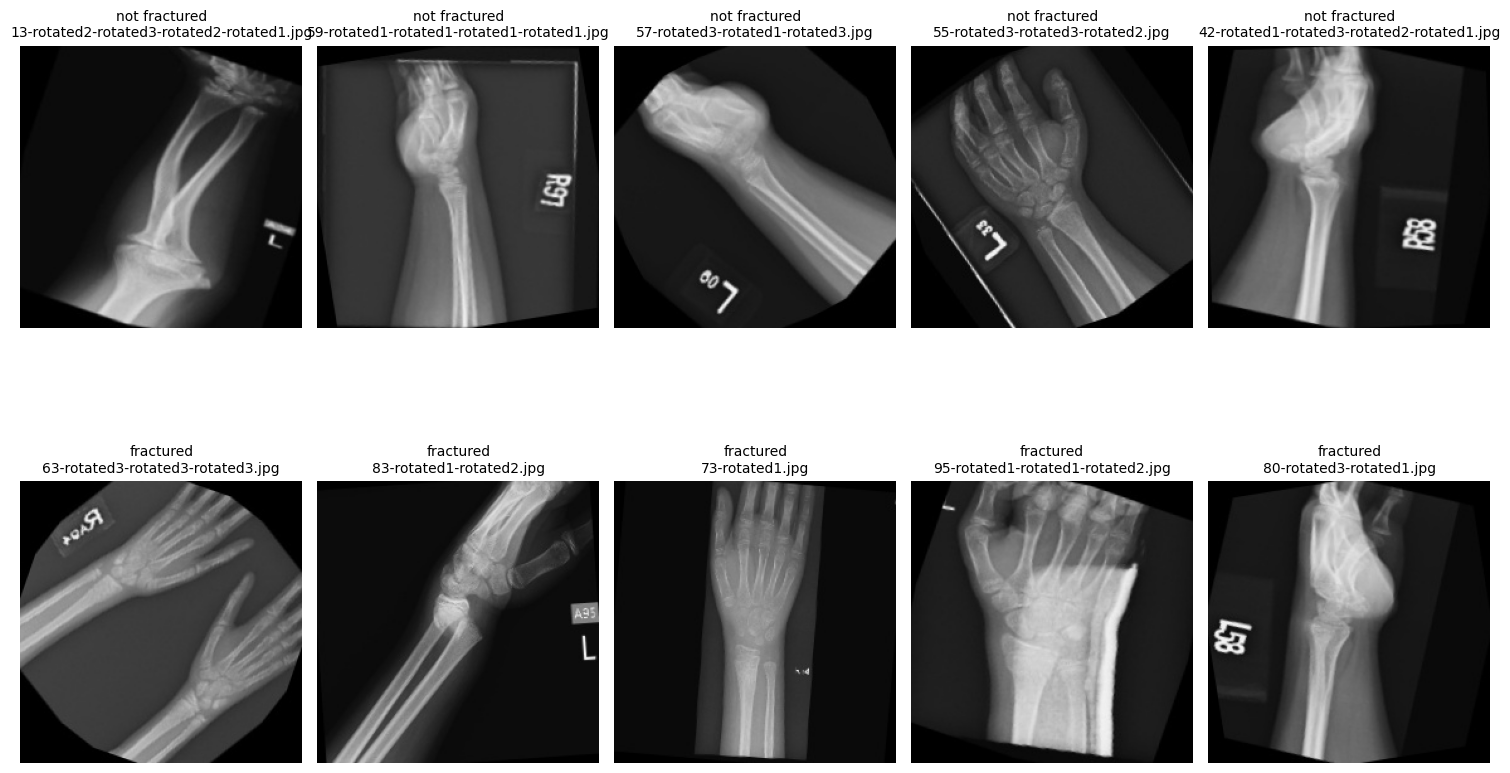

In [28]:
# Visualize sample images from the training set
print("\nVisualizing sample images from the training set:")
plot_sample_images(train_path, 5)

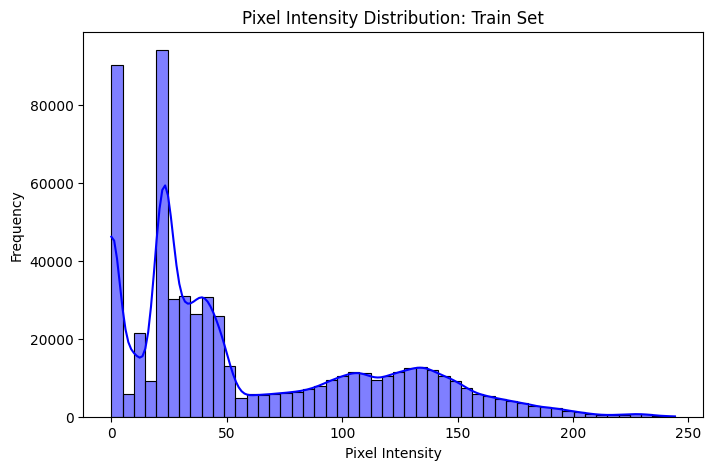

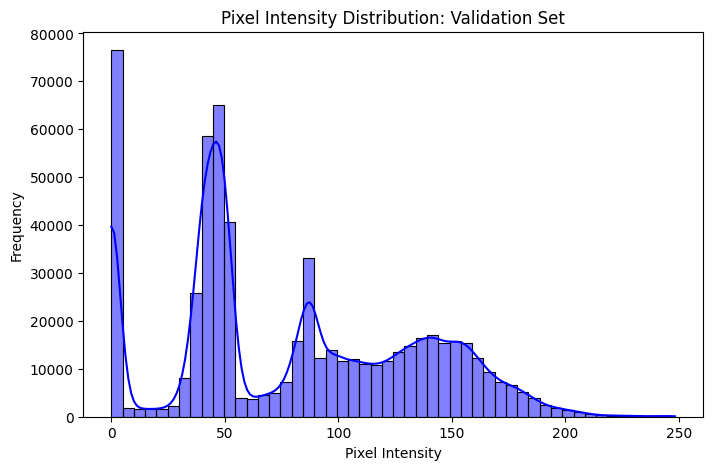

In [30]:
plot_pixel_distribution(train_generator, "Train Set")
plot_pixel_distribution(validation_generator, "Validation Set")

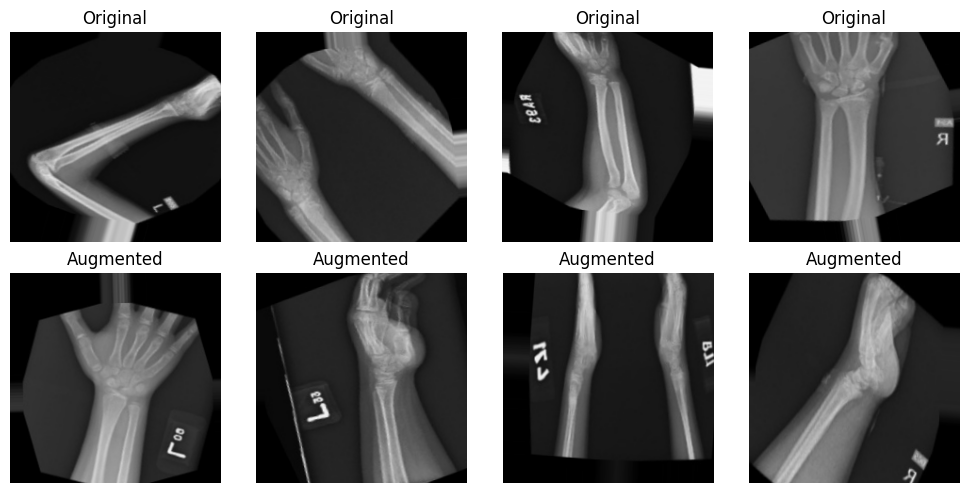

In [31]:
visualize_augmentation(train_generator)

# Model

In [32]:
# Define the model architecture
input_tensor = Input(shape=(224, 224, 3))

base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GaussianNoise(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = GaussianNoise(0.25)(x)
x = Dropout(0.25)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 11,573,040 (44.15 MB)

 Trainable params: 788,481 (3.01 MB)

 Non-trainable params: 10,784,559 (41.14 MB)

In [33]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [34]:
# Define callbacks for early stopping and learning rate reduction
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lrp = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)
call = [checkpoint, lrp]

# Training

In [35]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch=50,
    callbacks=call)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - AUC: 0.6377 - Precision: 0.5327 - Recall: 0.5658 - accuracy: 0.5870 - loss: 0.9963
Epoch 1: val_accuracy improved from -inf to 0.58333, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - AUC: 0.6380 - Precision: 0.5343 - Recall: 0.5672 - accuracy: 0.5878 - loss: 0.9960 - val_AUC: 0.6855 - val_Precision: 0.4892 - val_Recall: 0.9458 - val_accuracy: 0.5833 - val_loss: 0.8541 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - AUC: 0.7436 - Precision: 0.6615 - Recall: 0.6779 - accuracy: 0.6735 - loss: 0.6952
Epoch 2: val_accuracy did not improve from 0.58333
50/50 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - AUC: 0.7428 - Precision: 0.6609 - Recall: 0.6770 - accuracy: 0.6726 - loss: 0.6964 - val_AUC: 0.6175 - val_Precision: 0.4436 - val_Recall: 0.7542 - val_accuracy: 0.5233 - val_loss: 0.8482 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - AUC: 0.7767 - Precision: 0.7687 - Recal

# Evalutation

In [36]:
# Evaluate the model on training and validation data
model.evaluate(train_generator)
model.evaluate(validation_generator)

2216/2216 ━━━━━━━━━━━━━━━━━━━━ 1051s 474ms/step - AUC: 0.9084 - Precision: 0.7368 - Recall: 0.9527 - accuracy: 0.8091 - loss: 0.4382
150/150 ━━━━━━━━━━━━━━━━━━━━ 72s 482ms/step - AUC: 0.7631 - Precision: 0.5132 - Recall: 0.8768 - accuracy: 0.6451 - loss: 0.8411


[0.7998325228691101,
 0.6600000262260437,
 0.5489130616188049,
 0.8416666388511658,
 0.7592187523841858]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.29133335]]
THE UPLOADED X-RAY IMAGE IS: Fracture


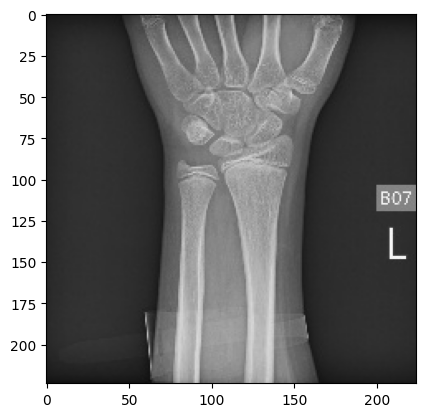

In [39]:
# Make predictions on a sample image
img = load_img('/content/archive (6)/val/not fractured/2-rotated1.jpg', target_size=(224, 224))
imag = img_to_array(img)
imaga = np.expand_dims(imag, axis=0)
ypred = model.predict(imaga)
print(ypred)

a = ypred[0]
if a < 0.5:
    op = "Fracture"
else:
    op = "Normal"

plt.imshow(img)
print("THE UPLOADED X-RAY IMAGE IS: " + str(op))

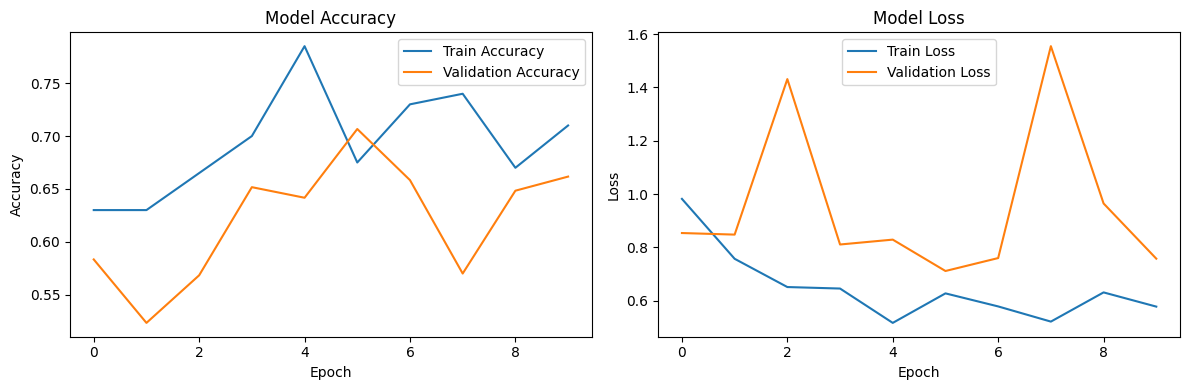

In [40]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

150/150 ━━━━━━━━━━━━━━━━━━━━ 79s 524ms/step

Confusion Matrix:


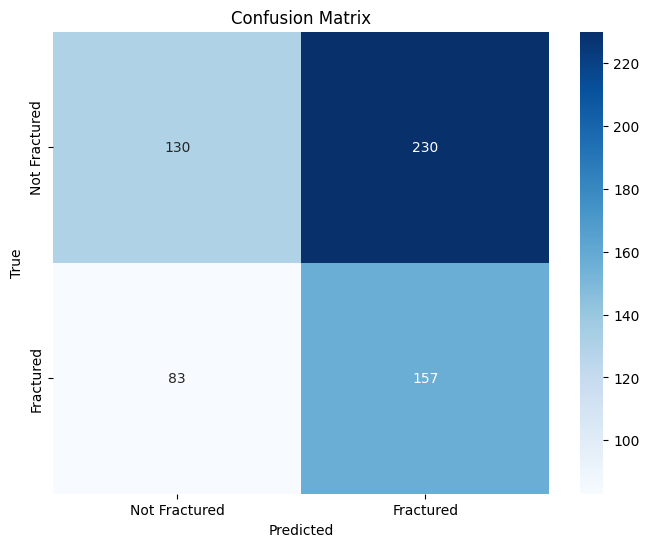


Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.61      0.36      0.45       360
    Fractured       0.41      0.65      0.50       240

     accuracy                           0.48       600
    macro avg       0.51      0.51      0.48       600
 weighted avg       0.53      0.48      0.47       600



In [43]:
# Plot confusion matrix and classification report
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

val_predictions = model.predict(validation_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)
val_true_classes = validation_generator.classes

print("\nConfusion Matrix:")
plot_confusion_matrix(val_true_classes, val_pred_classes, classes=['Not Fractured', 'Fractured'])

print("\nClassification Report:")
print(classification_report(val_true_classes, val_pred_classes, target_names=['Not Fractured', 'Fractured']))

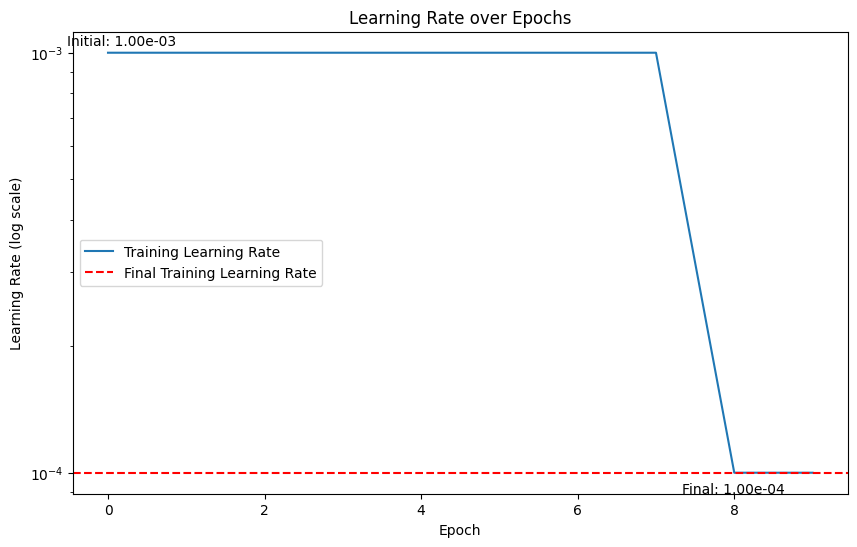

In [72]:
plot_metrics1('Learning Rate', 'learning_rate')

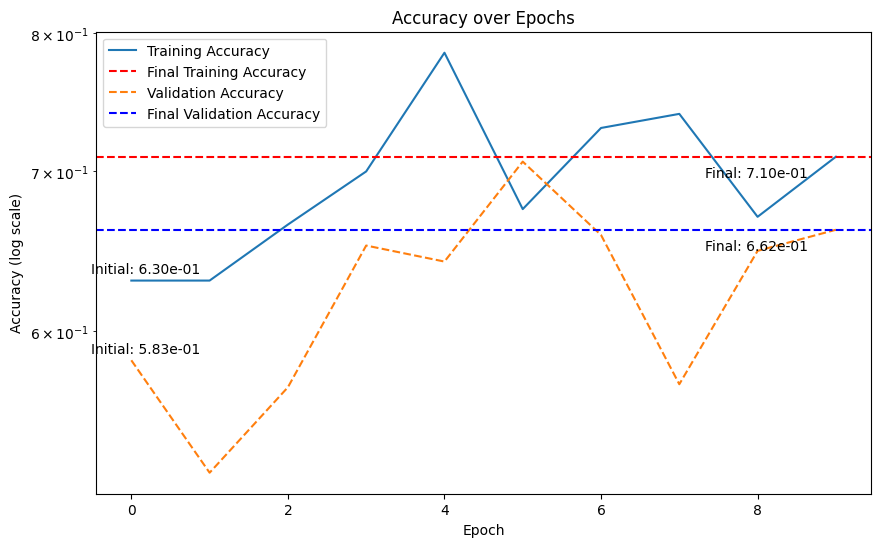

In [73]:
plot_metrics1('Accuracy', 'accuracy', 'val_accuracy')

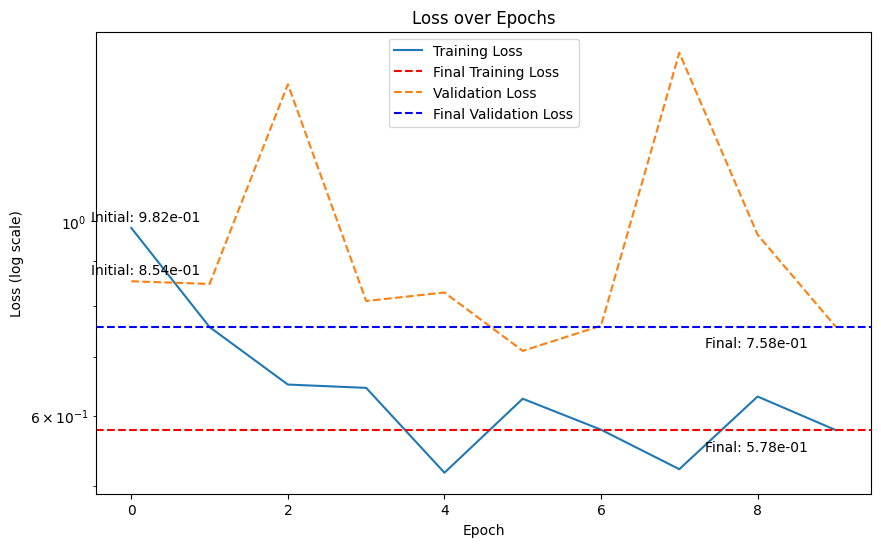

In [74]:
plot_metrics1('Loss', 'loss', 'val_loss')

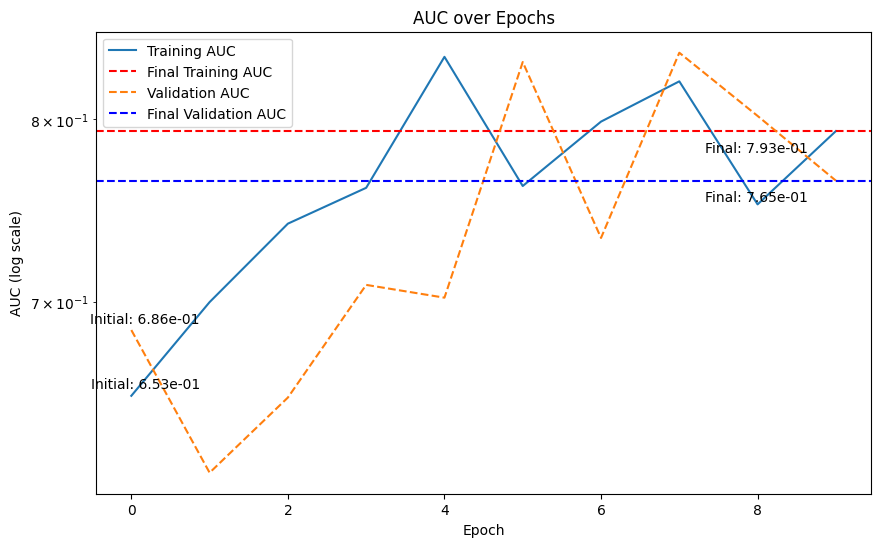

In [75]:
plot_metrics1('AUC', 'AUC', 'val_AUC')

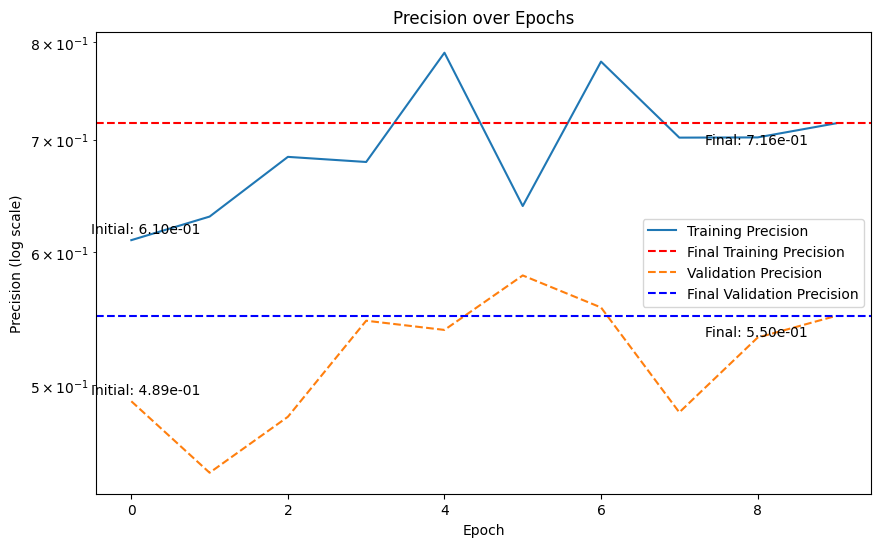

In [78]:
plot_metrics1('Precision', 'Precision', 'val_Precision')

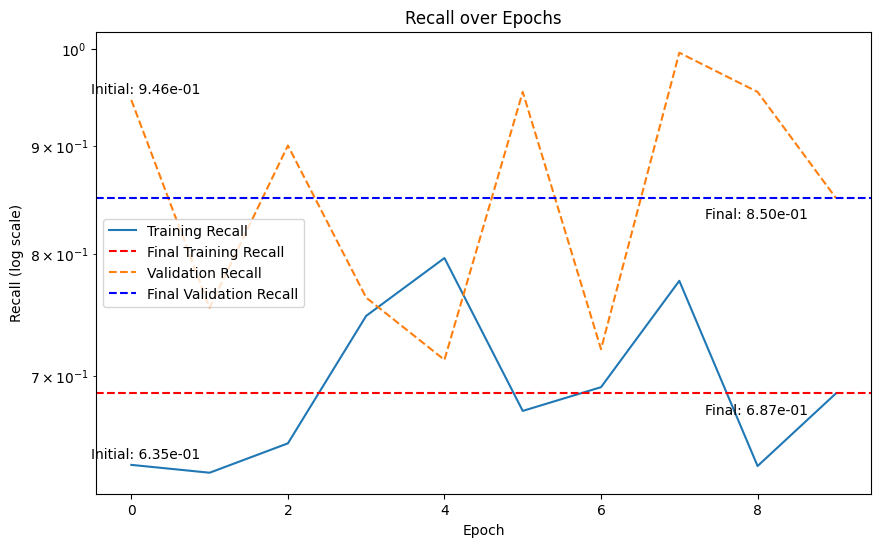

In [77]:
plot_metrics1('Recall', 'Recall', 'val_Recall')